In [26]:
import sys
sys.path.append("../src")

from news_headlines import RAW_DIR, preprocess_news, clean_headlines
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from charset_normalizer import from_path
import torch
from transformers import pipeline

## Making sure the format of all the news headlines files is the same

In [2]:
csv_files = list(RAW_DIR.glob("*_headlines.csv"))
csv_files

outputs = [preprocess_news(path) for path in csv_files]

## Merging the datasets

In [ ]:
paths_to_data = [
    Path("../data/preprocessed/cnbc_preprocessed.csv"),
    Path("../data/preprocessed/guardian_preprocessed.csv"),
    Path("../data/preprocessed/reuters_preprocessed.csv")
]

dfs = []

for path in paths_to_data:
    df = pd.read_csv(path, encoding="utf-8")
    dfs.append(df)

news_df = pd.concat(dfs, ignore_index=True)
news_df.head(10)

,Date,Headlines
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t..."
1,2018-03-20,Cramer's charts show 'signs of life' for the s...
2,2018-03-20,Information is 'the modern-day weapon' and we'...
3,2018-03-20,Cramer's lightning round: With so many great b...
4,2018-03-20,Cramer Remix: Here's how Mark Zuckerberg shoul...
5,2018-03-21,Cramer Remix: Goldman Sachs is the ideal stock...
6,2018-03-21,Cramer: What FedEx's earnings call reveals abo...
7,2018-03-21,Cramer's lightning round: Watch the technicals...
8,2018-03-21,Cramer: Facebook's troubles shouldn't weigh on...
9,2018-03-21,Cramer highlights the value of McDonald's: The...


In [ ]:
results = []

for path in paths_to_data:
    result = from_path(path).best()
    results.append(result)

print(results)

[<CharsetMatch 'utf_8' bytes(ea9fbe9f1b2d990326c13be374466e91106027e5b5f3f28d25ea5c4e4254515c)>, <CharsetMatch 'utf_8' bytes(1478a703431a57f16a5ff3f43e491a99221f1d94c1a87ee0a12abc2c5135f53d)>, <CharsetMatch 'utf_8' bytes(42d6a647025e186dc4eb43b6517f3daca8a23cc62dc538cb4cdc9ae0c2d71a1f)>]


In [5]:
news_df.to_csv("news.csv")

In [6]:
test = pd.read_csv("news.csv")

res = from_path("news.csv").best()
print("encoding:", res.encoding)
print("language:", res.language)
print("chaos%:", res.percent_chaos)   # lower is better
print("unicode_range:", res.alphabets)


encoding: utf_8
language: English
chaos%: 0.0
unicode_range: ['Basic Latin', 'Control character', 'Currency Symbols', 'General Punctuation', 'Latin Extended-A', 'Latin-1 Supplement', 'Letterlike Symbols']


### Checking for missing values, duplicates

In [7]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51122 entries, 0 to 51121
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       51122 non-null  object
 1   Headlines  51122 non-null  object
dtypes: object(2)
memory usage: 798.9+ KB


Date is an object (string), so we need to correct it into datetime

In [8]:
news_df["Date"] = pd.to_datetime(news_df["Date"])
news_df.info()
news_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51122 entries, 0 to 51121
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       51122 non-null  datetime64[ns]
 1   Headlines  51122 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 798.9+ KB


,Date,Headlines
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t..."
1,2018-03-20,Cramer's charts show 'signs of life' for the s...
2,2018-03-20,Information is 'the modern-day weapon' and we'...
3,2018-03-20,Cramer's lightning round: With so many great b...
4,2018-03-20,Cramer Remix: Here's how Mark Zuckerberg shoul...


In [9]:
news_df.describe()

,Date
count,51122
mean,2019-06-04 07:56:29.304018176
min,2018-03-20 00:00:00
25%,2018-10-31 00:00:00
50%,2019-06-08 00:00:00
75%,2020-01-21 00:00:00
max,2020-07-17 00:00:00


In [10]:
news_df.isna().sum()

Date         0
Headlines    0
dtype: int64

In [11]:
news_df.drop_duplicates() # this does nothing as there are no duplicates, but I'm leaving it here as a "sanity" check just for myself

,Date,Headlines
0,2018-03-20,"Cramer: Trump, the Fed and the cloud can get t..."
1,2018-03-20,Cramer's charts show 'signs of life' for the s...
2,2018-03-20,Information is 'the modern-day weapon' and we'...
3,2018-03-20,Cramer's lightning round: With so many great b...
4,2018-03-20,Cramer Remix: Here's how Mark Zuckerberg shoul...
...,...,...
51117,2020-07-17,Exclusive: Thyssenkrupp to explore further opt...
51118,2020-07-17,"UBS, Morgan Stanley expected to lead Vodafone ..."
51119,2020-07-17,As big U.S. banks let customers delay payments...
51120,2020-07-17,Fed opens 'Main Street' loan program to nonpro...


#### FinBERT is a transformer model trained on finance text, it can handle casing, subword tokenization, punctuation on its own, so I will not do the typical text cleaning steps like converting all text to lowercase. I'm trying not to clean the data too much, so we don't lose important information.

In [12]:
# looking for non-ASCII characters
mask_nonascii = news_df["Headlines"].str.contains(r"[^\x00-\x7F]")
news_df.loc[mask_nonascii, "Headlines"].head(10)


8     Cramer: Facebook's troubles shouldn't weigh on...
19    Cramer's lightning round: Hold XPO Logistics—i...
22    Wendy's just released a hip-hop mixtape—here's...
24    Cramer's lightning round: Buy AT&T—I think it'...
25    Cramer Remix: Facebook just flashed a classic ...
32    Cramer Remix: Hold the obits — the mall is ali...
38    Cramer Remix: The stock to get into if you can...
47    Tech stock prices were ‘not real life’ — and t...
59    Cramer Remix: If the jobs report is strong, it...
60    Cramer Remix: Don’t let fear keep you away fro...
Name: Headlines, dtype: object

In [13]:
# looking for zero width characters (or invisible characters)
mask_invisible = news_df["Headlines"].str.contains(r"[\u200B-\u200D\uFEFF\u00A0]")
news_df.loc[mask_invisible, "Headlines"].head(10)


452     Cramer: Tesla bears should think twice before ...
826     The market is 'scratching at the bottom' and w...
1610    11 years later: Cramer's 'They know nothing!' ...
2608    Next chief calls 2017 'toughest in 25 years' a...
2620    Project Syndicate economists  \n\n\n  The midd...
2672    ​Jaguar to supply 20,000 cars to Google's self...
2704    Melrose trio who sought biggest deal yet with ...
2871    Many reasons to be grateful to Bristol’s tobac...
2977    Business live  Britain's cost of living squeez...
3051    Nils Pratley on finance  \n\n\n  Shire saga sm...
Name: Headlines, dtype: object

In [14]:
# checking for double white space
mask_whitespace = news_df["Headlines"].str.contains(r"\s{2,}")
news_df.loc[mask_whitespace, "Headlines"].head(10)


2519    Business live  UK inflation rate hits seven-mo...
2530    Nils Pratley on finance  \n\n\n  Barclays wake...
2531    Business breakthroughs  Waterstones boss James...
2535    Business live  Facebook's value slides by $36b...
2537    Brief letters  Diarrhoea simply cannot be forg...
2546    Nils Pratley on finance  \n\n\n  Facebook inve...
2551    Brief letters  Bring your brolly if you come t...
2557    Business live  Global markets hit as Trump unv...
2567    Business made simple  Stuck in meetings all da...
2568    Nils Pratley on finance  \n\n\n  The UK should...
Name: Headlines, dtype: object

Non-ASCII: 3378 (6.61%)
Invisible chars: 112 (0.22%)
Excess whitespace: 2694 (5.27%)


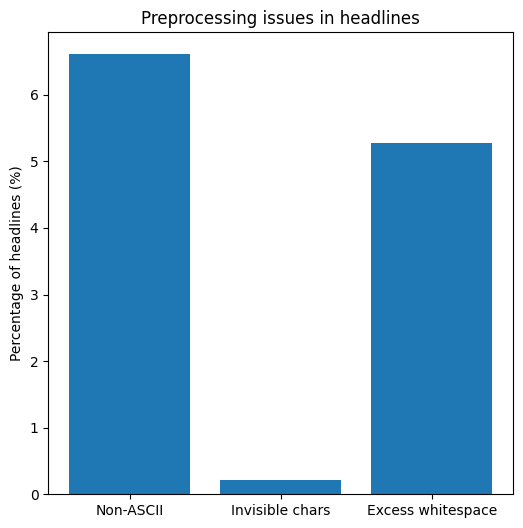

In [15]:
issues = {
    "Non-ASCII": mask_nonascii,
    "Invisible chars": mask_invisible,
    "Excess whitespace": mask_whitespace
}

labels = []
percentages = []

for name, mask in issues.items():
    count_issues = mask.sum()
    percent = count_issues / (len(news_df)) * 100
    print(f"{name}: {count_issues} ({percent:.2f}%)")
    labels.append(name)
    percentages.append(percent)

plt.figure(figsize=(6, 6))
plt.bar(labels, percentages)
plt.ylabel("Percentage of headlines (%)")
plt.title("Preprocessing issues in headlines")
plt.show()


In [16]:
print("Before cleaning:")
print(news_df.loc[5338:5342, "Headlines"].to_list())

news_df["Headlines"] = clean_headlines(news_df["Headlines"])

print("\nAfter cleaning:")
print(news_df.loc[5338:5342, "Headlines"].to_list())

Before cleaning:
['The Eva Wiseman column  \n\n\n  Poundworld’s demise is curiously heartbreaking news', "The strange saga of Elon Musk: inside his 'excruciating' year", "Timeline: Elon Musk's 'difficult and painful' 2018", 'Observer business agenda  \n\n\n  Is the homebuilders’ house of cards starting to wobble?', 'Are holiday homes ruining the British seaside?']

After cleaning:
['The Eva Wiseman column Poundworld’s demise is curiously heartbreaking news', "The strange saga of Elon Musk: inside his 'excruciating' year", "Timeline: Elon Musk's 'difficult and painful' 2018", 'Observer business agenda Is the homebuilders’ house of cards starting to wobble?', 'Are holiday homes ruining the British seaside?']


In [18]:
news_df.to_csv('../data/preprocessed/headlines.csv', index=False)

In [21]:
# find headlines that still contain quote characters inside the text
mask_quotes = news_df["Headlines"].str.contains(r'["“”]', na=False)
print(f"Headlines with stray quotes: {mask_quotes.sum()} ({mask_quotes.mean()*100:.2f}%)")
print(news_df.loc[mask_quotes, "Headlines"].head(10000).to_list())


Headlines with stray quotes: 30 (0.06%)
['Cramer Remix: What "Medicare for All" would mean for UnitedHealth Group', 'True North Doug Ford isn’t “for the little guy” – he’s a mercenary for the millionaire class', 'Business live Fed "kowtows to Trump"; UK inflation rises; Pound get Brexit jitters - as it happened', "Melrose’s 'Project Golf' bid for GKN beats engineer’s “Damson” defense", '"Very good chance" of a U.S.-China trade deal: Trump', 'Qatar Airways confirms "substantial" annual loss, blames regional row', 'South Korea antitrust chief says activist Elliott\'s Hyundai demand "inappropriate"', 'Toys "R" Us Canada gets court nod for assets sale', 'Trump\'s "muscle-flexing" with allies will cost US consumer, France says', 'Deutsche Bank\'s U.S. ops deemed "troubled" by Fed a year ago: WSJ', 'UK\'s Hammond says trade war would be "disaster" for U.S.: CNBC', 'For Greece\'s austerity-hit elderly, bailout "will never end"', 'Mars aims to tackle "broken" cocoa model with new sustainabilit

#### All of those are fine, so we are ready to proceed with FinBERT.